<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Multiple linear regression – advanced regression analysis 2
© ExploreAI Academy

In this notebook, we will delve into assessing the quality of a regression model by examining residuals for independence, homoscedasticity, normality, and outliers. We'll visualise residuals against predictor variables and fitted values and inspect histograms and Q-Q plots to ensure normality. Furthermore, we'll utilise Cook's distance to identify influential outliers.

## Learning objectives

By the end of this notebook, you should be able to:
* Interpret scatter plots of residuals against predictor variables to assess independence.
* Identify homoscedasticity by examining the relationship between fitted values and residuals.
* Evaluate the normality of residuals through histograms and Q-Q plots.
* Utilise Cook's distance to detect influential outliers in the dataset.
* Apply statistical techniques to ensure the robustness of regression models.


## The dataset: `mtcars`

For this train, we continue to make use of the `mtcars` dataset. We begin by importing the libraries that will help us load and explore our data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import ssl

# Set the path to the CA certificates bundle
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/mtcars.csv', index_col=0)
df.head(10)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
model,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,32.0,20.090625,6.026948,10.400,15.42500,19.200,22.80,33.900
cyl,32.0,6.187500,1.785922,4.000,4.00000,6.000,8.00,8.000
disp,32.0,230.721875,123.938694,71.100,120.82500,196.300,326.00,472.000
hp,32.0,146.687500,68.562868,52.000,96.50000,123.000,180.00,335.000
drat,32.0,3.596563,0.534679,2.760,3.08000,3.695,3.92,4.930
wt,32.0,3.217250,0.978457,1.513,2.58125,3.325,3.61,5.424
qsec,32.0,17.848750,1.786943,14.500,16.89250,17.710,18.90,22.900
vs,32.0,0.437500,0.504016,0.000,0.00000,0.000,1.00,1.000
am,32.0,0.406250,0.498991,0.000,0.00000,0.000,1.00,1.000
gear,32.0,3.687500,0.737804,3.000,3.00000,4.000,4.00,5.000


Let's make a copy of the dataset so that we can manipulate and process it with `statsmodels.OLS()`.

In [5]:
df1 = df.copy()

## Fitting the model using `statsmodels.OLS`

As previously mentioned, `sklearn` is limited in terms of the metrics and tools available to evaluate the appropriateness of the regression models we fit. Thus, to further expand our analysis, we import the `statsmodels` library and use it to generate the regression string, fit the model using `ols`, and finally, print the model summary.

In [6]:
import statsmodels.formula.api as sm

In [7]:
#Generate the regression string
formula_str = df1.columns[0]+' ~ '+'+'.join(df1.columns[1:])
formula_str

'mpg ~ cyl+disp+hp+drat+wt+qsec+vs+am+gear+carb'

In [8]:
#Construct and fit the model using ols
model=sm.ols(formula=formula_str, data=df1)
fitted = model.fit()

In [9]:
#Print the model summary
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.93
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           3.79e-07
Time:                        13:13:28   Log-Likelihood:                -69.855
No. Observations:                  32   AIC:                             161.7
Df Residuals:                      21   BIC:                             177.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3034     18.718      0.657      0.5

## Checking for independence

We have done checks for linearity and multicollinearity, which both refer to the predictor variables. Now we'll move on to checking some of the artefacts of the fitted model for three more statistical phenomena, which will further help us determine its quality.

### Residuals vs. predictor variable plots 

The first check is to plot the residuals (the vertical distances between each data point and the regression hyperplane). We're attempting to confirm the independence assumption, which states that the residuals should be independent. If residuals are independent, we expect to see that:

- Residuals are approximately uniformly and randomly distributed about the zero x-axes.

- Residuals are not forming any specific clusters.

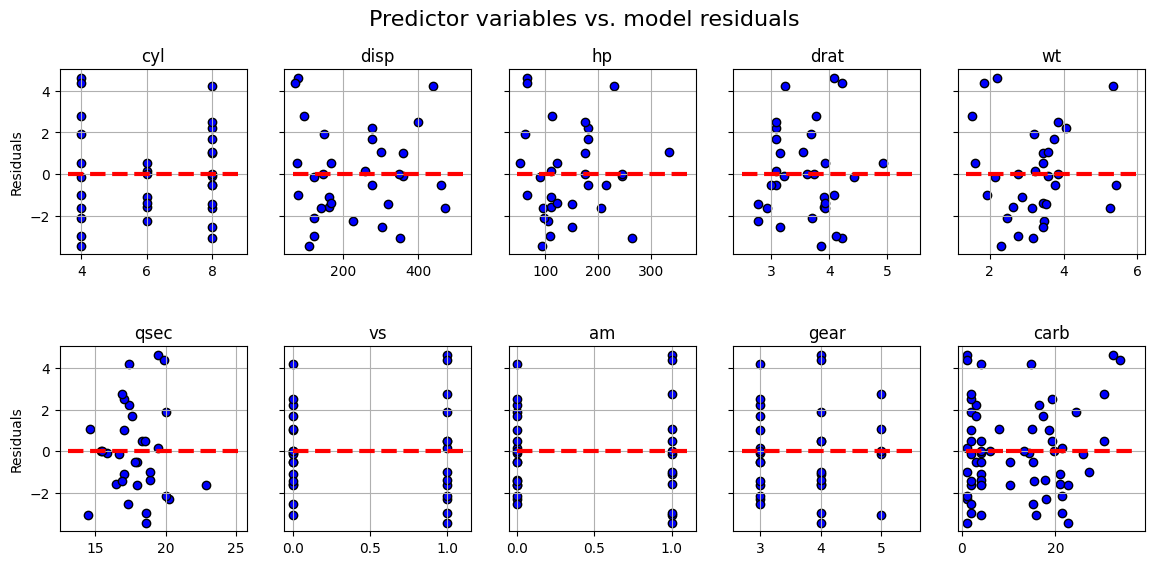

In [10]:
fig, axs = plt.subplots(2,5, figsize=(14,6),sharey=True)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
fig.suptitle('Predictor variables vs. model residuals', fontsize=16)
axs = axs.ravel()

for index, column in enumerate(df.columns):
    axs[index-1].set_title("{}".format(column),fontsize=12)
    axs[index-1].scatter(x=df[column],y=fitted.resid,color='blue',edgecolor='k')
    axs[index-1].grid(True)
    xmin = min(df[column])
    xmax = max(df[column])
    axs[index-1].hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    if index == 1 or index == 6:
        axs[index-1].set_ylabel('Residuals')

Observing the plots above, two things are relatively clear:

- All of the residuals are slightly skewed to the positive (reaching +5 to the positive but only up to about -3 to the negative).

- There is no obvious clustering.

Our conclusion here is that the residuals are largely independent.

## Checking for homoscedasticity

The next check will be to see if the variance of the residuals remains constant as the fitted values grow. 

### Fitted vs. residuals

We can assess the presence of homoscedasticity or heteroscedasticity by plotting the residuals against the fitted values (for example, `mpg`). In the case of homoscedasticity, the scatterplot should exhibit a random and uniform spread of points, indicating that the variance of the residuals remains constant across all levels of the predictor variable(s). Conversely, heteroscedasticity is evident when the spread of the residuals systematically changes as the fitted values increase or decrease, potentially resembling a cone shape.

Homoscedasticity implies a constant variance of the residuals across different levels of the predictor variable(s), while heteroscedasticity indicates varying variances. It's essential to detect and address heteroscedasticity as it can affect the validity of statistical inference and prediction.

Furthermore, examining the residuals plot can help identify outliers, which are data points that deviate significantly from the overall pattern of the residuals. Outliers should be carefully investigated as they can distort model assumptions and influence the estimation of parameters.

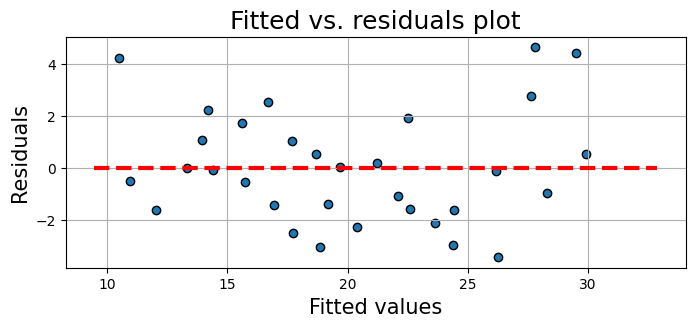

In [11]:
plt.figure(figsize=(8,3))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin = min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

The points towards the right-hand side of the plot tend to be scattered slightly less densely suggesting the possibility of heteroscedasticity, where the variance of the residuals may vary systematically with the magnitude of the predicted values. However, it's essential to confirm the presence of heteroscedasticity using formal statistical tests or diagnostic procedures designed for this purpose.

An example of a statistical test is the **Breusch-Pagan test**. This test examines whether the variance of the residuals is dependent on the independent variables in the regression model. It is based on regressing the squared residuals on the independent variables, and the significance of the resulting test statistic indicates the presence of heteroscedasticity.

To implement the Breusch-Pagan test in Python, we can use the `het_breuschpagan` function from the `statsmodels.stats` module.

We will implement the Breusch-Pagan test as follows:
* Calculate the residuals from your fitted regression model.
* Perform the Breusch-Pagan test using the residuals and the independent variables.

In [ ]:
import statsmodels.stats.api as sms

# 1. Calculate residuals
residuals = fitted.resid

# 2. Perform Breusch-Pagan test
bp_test_result = sms.het_breuschpagan(residuals, fitted.model.exog)
print("Breusch-Pagan Test Results:")
print("LM Statistic:", bp_test_result[0])
print("LM-Test p-value:", bp_test_result[1])
print("F-Statistic:", bp_test_result[2])
print("F-Test p-value:", bp_test_result[3])


When interpreting the results of the Breusch-Pagan test, we focus primarily on the p-values associated with the test statistics. 

Here's how we interpret the results:

**LM-Test p-value**: This is the p-value associated with the Lagrange Multiplier (LM) test statistic. It tests the null hypothesis that there is no heteroscedasticity (i.e. the variance of the residuals is constant across all levels of the predictors). In our case, the `LM-Test p-value` is `0.135`, which is greater than the typical significance level of 0.05. Therefore, we fail to reject the null hypothesis, indicating that there is no strong evidence of heteroscedasticity in the residuals.

**F-Test p-value**: This is the p-value associated with the F-statistic. It tests the same null hypothesis as the LM test but is based on a different statistic. In our case, the `F-Test p-value` is `0.116`, which is also greater than 0.05. Similarly, we fail to reject the null hypothesis based on the F-Test, further supporting the conclusion that there is no strong evidence of heteroscedasticity.

Overall, based on these results, we can conclude that there is **no significant evidence of heteroscedasticity** in the residuals of the regression model which  implies that the assumption of homoscedasticity is likely satisfied. In other words, the variance of the residuals remains relatively constant across different levels of the predictor variables.

This is a desirable outcome because homoscedasticity is one of the key assumptions of linear regression analysis. When homoscedasticity is present, the **estimated coefficients are unbiased** and the **standard errors are reliable**, leading to **valid statistical inference**. Additionally, predictions and confidence intervals are more accurate and trustworthy when the assumption of homoscedasticity holds true.

## Checking for normality
Here we attempt to confirm our assumption of normality amongst the residuals. If the residuals are non-normally distributed, confidence intervals can become too wide or too narrow, which leads to difficulty in estimating coefficients based on the minimisation of ordinary least squares.

We can check for violations of the normality assumption in two different ways:

1. Plotting a histogram of the normalised residuals.

2. Generating a Q-Q plot of the residuals.

### Histogram of normalised residuals

We create a histogram of the residuals to examine their distribution. It is fairly easy to recognise when a distribution resembles the classic **_bell curve_** shape of the normal distribution.

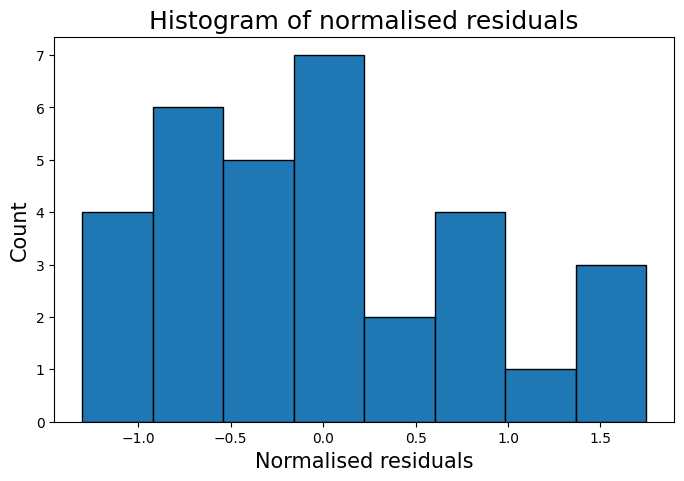

In [14]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=8,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalised residuals',fontsize=15)
plt.title("Histogram of normalised residuals",fontsize=18)
plt.show()

### Q-Q plot of the residuals

A Q-Q plot, short for quantile-quantile plot, compares the quantiles of the residuals against the quantiles of the theoretical standard normal distribution. In the plot, the one-to-one line (shown in red) represents perfect agreement with the theoretical distribution, indicating normality. The proximity of the plotted points to this red line indicates how closely the distribution of residuals matches the standard normal distribution. Closer alignment suggests a stronger resemblance to normality.

In [ ]:
# We once again use the statsmodel library to assist us in producing our qqplot visualisation.
from statsmodels.graphics.gofplots import qqplot

<Figure size 800x500 with 0 Axes>

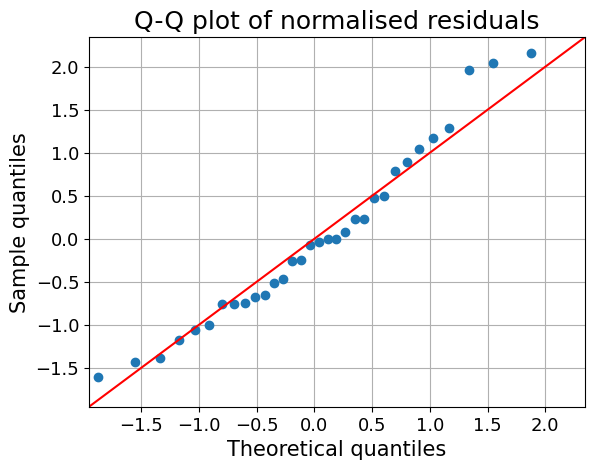

In [16]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalised residuals",fontsize=18)
plt.grid(True)
plt.show()

Based on the two checks above, the residuals appear to be regularly distributed.

## Checking for outliers in residuals

The last check we'll make is for outliers amongst the residuals.

### Plotting Cook's distance

Cook's distance is a measure used in regression analysis to assess the influence of individual data points on the regression model. It quantifies how much the model's predictions change when a particular observation is removed from the dataset.

Observations with large Cook's distances have a disproportionate impact on the model, meaning that they significantly influence the estimated coefficients and overall fit of the regression model. These observations can potentially be influential outliers or leverage points that have a substantial effect on the regression results.

Therefore, it is common practice to examine observations with large Cook's distances more closely to determine if they are genuine outliers or influential points that need special consideration in the analysis. 

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [18]:
inf=influence(fitted)

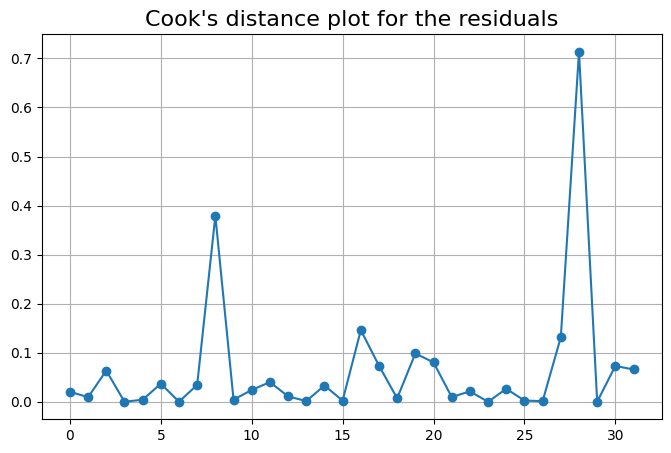

In [19]:
(c, p) = inf.cooks_distance
plt.figure(figsize=(8, 5))
plt.title("Cook's distance plot for the residuals", fontsize=16)
plt.plot(np.arange(len(c)), c, marker='o', linestyle='-')
plt.grid(True)
plt.show()

There are at least two values with much higher Cook's distances than the rest. A rule of thumb for determining whether a Cook's distance is too large is whether it significantly exceeds 1 or is greater than or equal to the value of 4 divided by the number of observations in the dataset.

It does appear that observations 8 and 28 are highly influential in this dataset, and may warrant closer examination.

## Summary

In this notebook, we embarked on a journey to evaluate the quality of a regression model through a thorough analysis of its residuals. We meticulously examined four key statistical phenomena: **independence**, **homoscedasticity**, **normality**, and **outliers**. Employing visualisations such as **scatter plots** of residuals against predictor variables, **histograms**, and **Q-Q plots**, we scrutinised the adherence of the residuals to these fundamental assumptions. Additionally, we utilised **Cook's distance** to pinpoint influential outliers in the dataset. By the end of this exploration, we gained insights into **interpreting residuals**, **identifying patterns**, and **diagnosing potential issues** in regression models. Armed with this knowledge, we've equipped ourselves with a robust set of tools to ensure the reliability and accuracy of our regression analyses.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>